In [1]:
# Torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.optim as optim
from torcheval.metrics import *

# Benny pointnet
from pointnet2_benny import pointnet2_cls_msg
from pointnet2_benny import provider

# Other
from tqdm import tqdm
import nibabel
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score
from collections import Counter

# Custom modules
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *

In [2]:

class SubjectDataset(Dataset):
    def __init__(self, data_path, labels_of_interest):
        
        if len(labels_of_interest) < 2 or len(labels_of_interest) > 3:
            
            print("Error, must have 2 or 3 classes \n")
            
            return
        
        if labels_of_interest[0] != 'CN':
            
            print("Error, ordering of labels incorrect")
            
            return
        
        self.labels_of_interest = labels_of_interest
        
        self.num_classes = len(labels_of_interest)
        
        subject_list = []
        
        # Include only the subjects that have a label of interest
        for subject in find_subjects(data_path):
            
            if subject.xml_df['idaxs']['project']['subject']['researchGroup'] in labels_of_interest:
            
                subject_list.append(subject)
                
            else:
                
                continue
        
        self.subject_list = subject_list

    def __len__(self):
        
        return len(self.subject_list)

    def __getitem__(self, index):
        
        subject = self.subject_list[index]
        
        
        """IMAGES"""
        
        # Aligned cropped brain
        brain = self.load_mri_to_tensor(subject.brain_aligned_cropped)
        
        # NB these are all cropped
        hcampus_vox = self.load_mri_to_tensor(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_cropped.nii'))
        
        hcampus_vox_aligned = self.load_mri_to_tensor(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped.nii'))
    
        hcampus_pointcloud = torch.tensor(np.load(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_cropped_mesh_downsampled.npy')), dtype=torch.float32)
                                          
        hcampus_pointcloud_aligned = torch.tensor(np.load(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped_mesh_downsampled.npy')), dtype=torch.float32)
        
        
        """REGION VOLUME STATS"""
        
        aseg_stats = subject.aseg_stats
        
        
        """SUBJECT INFO - NB NOT COMPLETE WITH SCORES, NEED TO PARSE XML"""
    
        # Info from subject XML
        subject_dict = subject.xml_df
        
        # Convert research group disease label str to number for pytorch
        if len(self.labels_of_interest) == 3:
            
            mapping = {
                'CN': 0,
                'MCI': 1,
                'AD': 2
            }
            
        elif len(self.labels_of_interest) == 2:
        
            mapping = {
                'CN': 0,
                'MCI': 1,
                'AD': 1
            }

        
        # Get the value of the mapping, -1 if not found
        research_group = mapping.get(subject_dict['idaxs']['project']['subject']['researchGroup'], -1)
        
        visit_identifier = subject_dict['idaxs']['project']['subject']['visit']['visitIdentifier']
        
        sex = subject_dict['idaxs']['project']['subject']['subjectSex']
        
        age = subject_dict['idaxs']['project']['subject']['study']['subjectAge']
        
        weight = subject_dict['idaxs']['project']['subject']['study']['weightKg']
        
        apoe_a1 = subject_dict['idaxs']['project']['subject']['subjectInfo'][0]['#text']
        
        apoe_a2 = subject_dict['idaxs']['project']['subject']['subjectInfo'][1]['#text']
            
        
        # Scores
        

        # Return a dictionary with your data
        return {
            'brain': brain,
            'hcampus_vox': hcampus_vox,
            'hcampus_vox_aligned': hcampus_vox_aligned,
            'hcampus_pointcloud': hcampus_pointcloud,
            'hcampus_pointcloud_aligned': hcampus_pointcloud_aligned,
            'aseg_stats': aseg_stats,
            'research_group': research_group,
            'visit_identifier': visit_identifier,
            'sex': sex,
            'age': age,
            'weight': weight,
            'apoe_a1': apoe_a1,
            'apoe_a2': apoe_a2,
        }
        
    def load_mri_to_tensor(self, path):
        
        if path is None or not os.path.isfile(path):
            return torch.empty(0)  # Return empty tensor if the file doesn't exist
        
        # Example of using nibabel to load .mgz files (you can modify as needed)
        image = nibabel.load(path)

        image_data = image.get_fdata()
        
        # Convert to PyTorch tensor
        tensor_data = torch.tensor(image_data, dtype=torch.float32)
        
        return tensor_data

def collate_fn(keys_of_interest):

    def collate_fn_inner(batch):
        
        batch_data = {}

        for key in keys_of_interest:

            if all(key in item for item in batch):

                if isinstance(batch[0][key], torch.Tensor):
                    
                    batch_data[key] = torch.stack([item[key] for item in batch if key in item])
                    
                else:

                    batch_data[key] = torch.tensor([item[key] for item in batch if key in item], dtype=torch.long)
                    
            else:
                
                print(f"Key error")
        
        return batch_data

    return collate_fn_inner

'def collate_fn(keys_of_interest):\n\n    def collate_fn_inner(batch):\n        \n        batch_data = {}\n\n        for key in keys_of_interest:\n\n            if all(key in item for item in batch):\n\n                if isinstance(batch[0][key], torch.Tensor):\n                    \n                    batch_data[key] = torch.stack([item[key] for item in batch if key in item])\n                    \n                else:\n\n                    batch_data[key] = torch.tensor([item[key] for item in batch if key in item], dtype=torch.long)\n                    \n            else:\n                \n                print(f"Key error")\n        \n        return batch_data\n\n    return collate_fn_inner'

In [3]:
def split_dataset(dataset, test_size=0.2):
    
    dataset_size = len(dataset)
    
    test_size = int(test_size * dataset_size)
    
    train_size = dataset_size - test_size
    
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    return train_dataset, test_dataset

### Dataset creation

In [4]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch disk/full-datasets/adni1-complete-3T-processed"

labels_of_interest = ['CN', 'MCI']

dataset = SubjectDataset(data_path, labels_of_interest)

### Data checks

In [5]:
print(f"Dataset size: {len(dataset)}\n")

labels = []

for subject in range(len(dataset.subject_list)):
    
    group = dataset.__getitem__(subject)['research_group']
    
    # print(f"{group}\n")
    
    labels.append(group)
    
print(f"Unique labels: {np.unique(labels)}\n")

print("Labels count:\n")
print(Counter(labels))



Dataset size: 386

Unique labels: [0 1]

Labels count:

Counter({1: 226, 0: 160})


### Loader config

In [6]:
# Dictionary key representing the data of interest
data_string = 'hcampus_pointcloud'

# Dictionary key representing the disease labels
labels_string = 'research_group'

train_data, test_data = split_dataset(dataset, test_size = 0.2)

train_dataloader = DataLoader(train_data, batch_size = 16, shuffle=True, collate_fn=collate_fn([data_string, labels_string]))

test_dataloader = DataLoader(test_data, batch_size = 16, shuffle=False, collate_fn=collate_fn([data_string, labels_string]))



### Cuda setup

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [8]:
from torcheval.metrics import *

torch.cuda.empty_cache()

num_epochs = 3

num_classes = dataset.num_classes

training_losses, validation_losses = [], []

model = pointnet2_cls_msg.get_model(num_classes, normal_channel=False)

criterion = pointnet2_cls_msg.get_loss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Reset optimizer between runs
optimizer.zero_grad()

model.to(device)

for epoch in range(num_epochs):
    
    print(f"Starting epoch {epoch + 1}\n")
    
    # Training loop
    model.train()
    
    running_loss = 0.0

    for batch_idx, dict in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        points = dict[data_string]
        labels = dict[labels_string]
        
        # Benny script augmentation
        '''
        points = points.numpy()
        points = provider.random_point_dropout(points)
        points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)'''
        
        # Transpose as in benny script (NB why does it need a transpose)
        points = points.transpose(2, 1)
        
        points, labels = points.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        pred_probability, _ = model(points)

        # Calculate loss, trans_feat argument as None as not used in this function
        loss = criterion(pred_probability, labels, None)

        loss.backward()
        optimizer.step()
        
        # Loss is the loss value multiplied by the batch size, given by the first dimension of the batch tensor
        running_loss += loss.item() * points.size(0)
        
    training_losses.append(running_loss/len(train_dataloader))
    
    # Validation loop
    model.eval()
    
    with torch.no_grad():
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        conf_matrix = np.zeros((num_classes, num_classes))
        
        conf_matrix_torch = BinaryConfusionMatrix()
        
        accuracy = BinaryAccuracy()
        
        for batch_idx, dict in enumerate(test_dataloader):
            
            points = dict[data_string]
            labels = dict[labels_string]
            
            points = points.transpose(2, 1)
            
            points, labels = points.to(device), labels.to(device)
            
            pred_probability, _ = model(points)
            
            #print(pred_probability)
            
            loss = criterion(pred_probability, labels, None)
            
            running_loss = loss.item() * points.size(0)
            
            # Do we want to apply exp as the preds of the model are log softmax?
            pred_labels = torch.argmax(pred_probability, dim=-1)
            
            #print(pred_labels)
            #print(labels)
            
            conf_matrix += confusion_matrix(labels.cpu().numpy(), pred_labels.cpu().numpy(), labels = np.arange(num_classes))
            
            #report = classification_report(labels.cpu().numpy(), pred_labels.cpu().numpy())
            
            #auc = roc_auc_score(labels, pred_probability)
            
            conf_matrix_torch.update(pred_labels, labels)
            
            accuracy.update(pred_labels, labels)
            
            
            
    print(conf_matrix_torch.compute())
    
    print(accuracy.compute())
                 
                    
    #ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_of_interest).plot()
    
    validation_losses.append(running_loss/len(test_dataloader))
    
    print(f"\n Epoch {epoch + 1} complete\n")
    print(f"Training loss: {training_losses[-1]}\n")
    print(f"Validation loss: {validation_losses[-1]}\n")
    print("------------------------\n\n\n")

torch.save(model.state_dict(), 'trained_model.pth')
print("Training complete and model saved")

torch.cuda.empty_cache()

Starting epoch 1



100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


tensor([[ 0., 36.],
        [ 0., 41.]])
tensor(0.5325)

 Epoch 1 complete

Training loss: 11.129884617030621

Validation loss: 4.572158837318421

------------------------



Starting epoch 2



100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


tensor([[36.,  0.],
        [41.,  0.]])
tensor(0.4675)

 Epoch 2 complete

Training loss: 11.845938503742218

Validation loss: 1.4382938265800476

------------------------



Starting epoch 3



100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


tensor([[ 0., 36.],
        [ 1., 40.]])
tensor(0.5195)

 Epoch 3 complete

Training loss: 10.3896005615592

Validation loss: 2.7383296251297

------------------------



Training complete and model saved


### Plotting

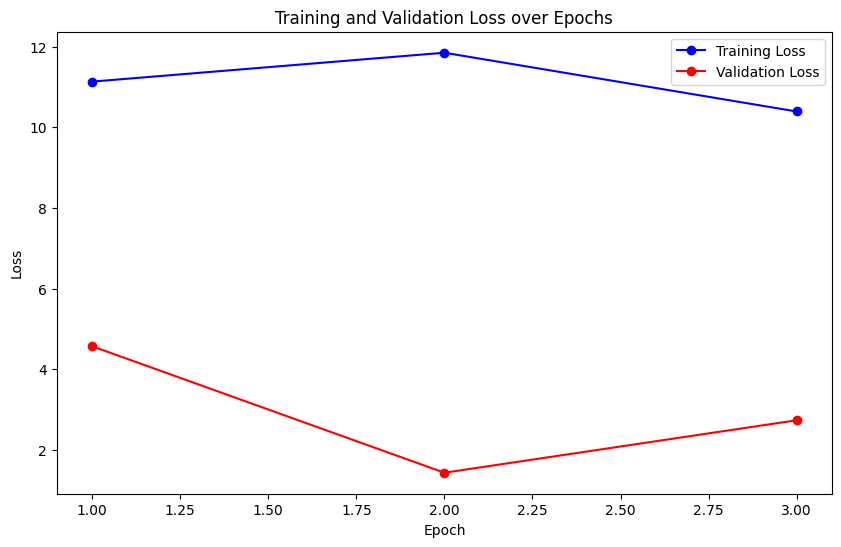

In [9]:
# After training, plot the losses
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue', marker='o')

# Plot validation loss
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='red', marker='o')

# Add labels and title
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()
